In [120]:
# imports and plotting utility functions
%matplotlib inline
import numpy as np
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import ShuffleSplit
from sklearn.linear_model import Lasso
import seaborn as sns
from matplotlib import pylab as plt
from statsmodels.regression.linear_model import OLS

def plot_lr(true_coefs, est_coefs, pvals):
    where_sign = lr_pvalues < 0.05
    plt.figure(figsize=(15, 7))
    plt.scatter(np.arange(X.shape[1]), true_coefs, color='black', label='true betas', alpha=0.5)
    # print non-significant betas
    plt.scatter(np.arange(X.shape[1]), est_coefs, color='red', label='estimated betas', alpha=0.5)
    # print significant betas
    axes = plt.gca()
    y_max, _ = axes.get_ylim()
    sign_y = np.sum(where_sign) * [y_max]
    plt.scatter(np.arange(X.shape[1])[where_sign], sign_y, color='red', label='significant at p<0.05', s=150, marker=(5, 1), alpha=0.75, linewidth=3)

    plt.xlabel('input variables')
    #plt.xticks(np.arange(n_feat)[::2], (np.arange(n_feat) + 1)[::2])
    plt.xticks(np.arange(n_feat), (np.arange(n_feat) + 1))
    plt.grid(True)
    plt.title('Linear regression', fontsize=16)
    plt.legend(loc='upper right')

def plot_regr_paths(coefs, accs, nonzeros, C_grid):
    n_cols = 2
    n_rows = 1
    n_verticals = len(coefs)

    my_palette = np.array([
        '#F47D7D', '#FBEF69', '#98E466', '#000000',
        '#A7794F', '#CCCCCC', '#85359C', '#FF9300', '#FF0030', 'grey', 'blue', 'salmon', '#4BBCF6',
        'green', 'tomato', 'darkred', 'black', 'cyan', 'lime'
    ])
    my_colors = np.array(['???????'] * coefs.shape[-1])
    i_col = 0
    new_grp_pts_x = []
    new_grp_pts_y = []
    new_grp_pts_col = []
    new_grp_pts_total = []

    for i_vertical, (params, acc, C) in enumerate(zip(
        coefs, accs, C_grid)):
        b_notset = my_colors == '???????'
        b_nonzeros = params == 0
        b_coefs_of_new_grp = np.logical_and(b_notset, b_nonzeros)

        #if i_vertical >= 17:
        #    import pdb; pdb.set_trace()

        if np.sum(b_coefs_of_new_grp) > 0:
            i_col += 1

            # we found a new subset that became 0
            for new_i in np.where(b_coefs_of_new_grp == True)[0]:
                # color all coefficients of the current group
                cur_col = my_palette[i_col]
                my_colors[new_i] = cur_col

            new_grp_pts_x.append(C)
            new_grp_pts_y.append(acc)
            new_grp_pts_col.append(cur_col)
            new_grp_pts_total.append(np.sum(b_nonzeros))

    X_colnames = np.arange(n_feat) + 1
    subplot_xlabel = '#nonzero coefficients'

    f, axarr = plt.subplots(nrows=n_rows, ncols=n_cols,
        figsize=(15, 10), facecolor='white')
    t, i_col = 0, 0

    for i_line in range(X.shape[-1]):
        axarr[i_col].plot(np.log10(C_grid),
            coefs[:, i_line], label=X_colnames[i_line],
                color=my_colors[i_line], linewidth=1.5)

    # axarr[0].set_xticks(np.arange(len(C_grid)))
    # axarr[0].set_xticklabels(np.log10(C_grid))  #, rotation=75)
    axarr[i_col].set_xlabel(subplot_xlabel, fontsize=10)
    axarr[i_col].legend(loc='lower left', fontsize=8.5)
    axarr[0].grid(True)
    # axarr[i_col].set_ylabel('Item groups', fontsize=16)
    axarr[0].set_title('LASSO: Groups of selected variables', fontsize=16)
    axarr[0].set_xticks(np.log10(C_grid))
    axarr[0].set_xticklabels(nonzeros)

    # axarr[1].axis('off')
    axarr[1].plot(np.arange(len(accs)), accs, color='#000000',
                     linewidth=3)
    # axarr[1].set_title('ACCURACY')
    axarr[1].set_ylim(0.0, 1.05)
    axarr[1].grid(True)
    # axarr[1].set_xticklabels(np.log10(C_grid), '')
    axarr[1].set_xticks(np.arange(n_verticals))
    axarr[1].set_xticklabels(nonzeros)
    axarr[1].set_xlabel(subplot_xlabel, fontsize=10)
    # axarr[1].set_ylabel('Out-of-sample accuracy', fontsize=16)
    axarr[1].set_title('LASSO: Out-of-sample accuracy ($R^2$ score)', fontsize=16)

In [121]:
# statistical helper functions
def compute_Lasso_regpath(X, y, C_grid):
    coef_list2 = []
    acc_list2 = []
    nonzero_list2 = []
    for i_step, my_C in enumerate(C_grid):
        sample_accs = []
        sample_coef = []
        for i_subsample in range(100):
            folder = ShuffleSplit(n=len(y), n_iter=100, test_size=0.1,
                                            random_state=i_subsample)
            train_inds, test_inds = iter(folder).next()

            clf = Lasso(alpha=my_C, random_state=i_subsample)

            clf.fit(X[train_inds, :], y[train_inds])
            acc = clf.score(X[test_inds, :], y[test_inds])

            sample_accs.append(acc)        
            sample_coef.append(clf.coef_)

        mean_coefs = np.mean(np.array(sample_coef), axis=0)
        coef_list2.append(mean_coefs)
        acc_list2.append(np.mean(sample_accs))
        notzero = np.count_nonzero(mean_coefs)
        print "alpha: %.4f acc: %.2f active_coefs: %i" % (my_C, acc, notzero)
        nonzero_list2.append(notzero)
    return np.array(coef_list2), np.array(acc_list2), np.array(nonzero_list2)

# __100 samples, 40 variables, error = N(0, 1)__

alpha: 0.0100 acc: 0.57 active_coefs: 40
alpha: 0.0127 acc: 0.60 active_coefs: 40
alpha: 0.0162 acc: 0.64 active_coefs: 40
alpha: 0.0205 acc: 0.68 active_coefs: 40
alpha: 0.0261 acc: 0.72 active_coefs: 40
alpha: 0.0332 acc: 0.76 active_coefs: 40
alpha: 0.0422 acc: 0.79 active_coefs: 40
alpha: 0.0536 acc: 0.80 active_coefs: 40
alpha: 0.0681 acc: 0.80 active_coefs: 40
alpha: 0.0866 acc: 0.80 active_coefs: 39
alpha: 0.1101 acc: 0.80 active_coefs: 32
alpha: 0.1399 acc: 0.78 active_coefs: 24
alpha: 0.1778 acc: 0.76 active_coefs: 19
alpha: 0.2260 acc: 0.70 active_coefs: 15
alpha: 0.2873 acc: 0.62 active_coefs: 13
alpha: 0.3652 acc: 0.55 active_coefs: 7
alpha: 0.4642 acc: 0.44 active_coefs: 6
alpha: 0.5900 acc: 0.32 active_coefs: 6
alpha: 0.7499 acc: 0.22 active_coefs: 4
alpha: 0.9532 acc: 0.04 active_coefs: 2
alpha: 1.2115 acc: -0.19 active_coefs: 2
alpha: 1.5399 acc: -0.22 active_coefs: 1
alpha: 1.9573 acc: -0.22 active_coefs: 0
alpha: 2.4879 acc: -0.22 active_coefs: 0
alpha: 3.1623 acc: -0

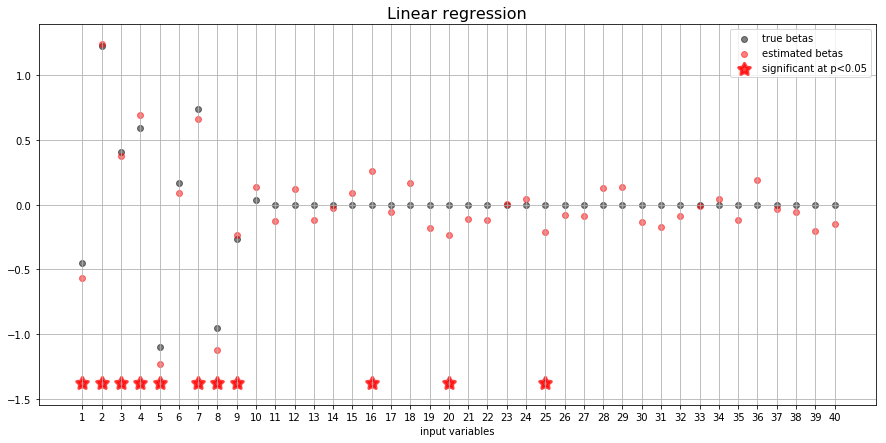

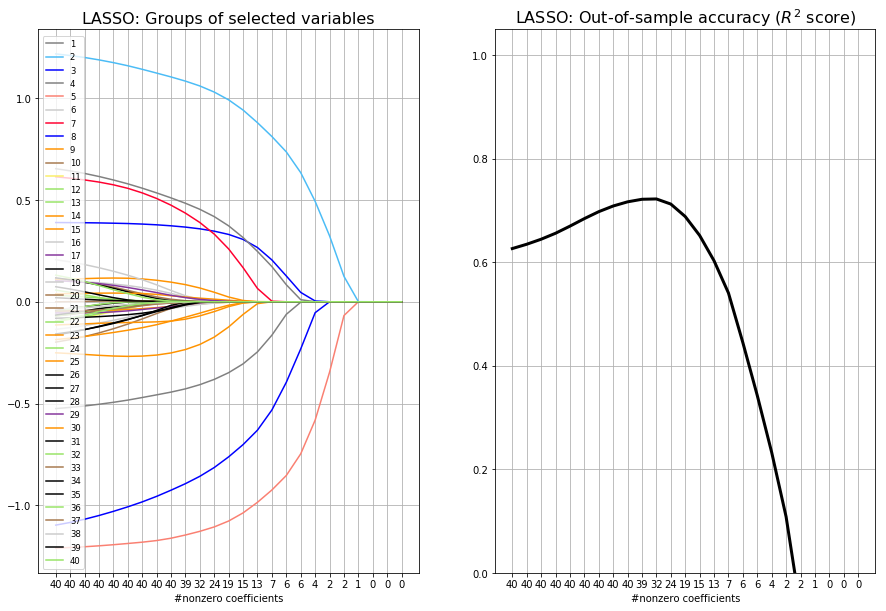

In [122]:
# dataset: 10/40 variables relevant, linear ground truth, some noise
rs = np.random.RandomState(1)
n_samples = 100
n_feat = 40
n_feat_relevant = 10
epsilon = rs.randn(n_samples)
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)
y = (true_coefs * X).sum(axis=1) + epsilon

# ordinary least squares
model = OLS(y, X)
res = model.fit()
lr_coefs = res.params
lr_pvalues = res.pvalues

# compute Lasso regularization paths
C_grid = np.logspace(-2, 0.5, 25)
coef_list, acc_list, nonzero_list = compute_Lasso_regpath(X, y, C_grid)

plot_lr(true_coefs, lr_coefs, lr_pvalues)
plot_regr_paths(coef_list, acc_list, nonzero_list, C_grid)

alpha: 0.0100 acc: 0.85 active_coefs: 40
alpha: 0.0127 acc: 0.86 active_coefs: 40
alpha: 0.0162 acc: 0.87 active_coefs: 40
alpha: 0.0205 acc: 0.87 active_coefs: 40
alpha: 0.0261 acc: 0.88 active_coefs: 40
alpha: 0.0332 acc: 0.89 active_coefs: 40
alpha: 0.0422 acc: 0.91 active_coefs: 40
alpha: 0.0536 acc: 0.91 active_coefs: 40
alpha: 0.0681 acc: 0.91 active_coefs: 38
alpha: 0.0866 acc: 0.90 active_coefs: 36
alpha: 0.1101 acc: 0.88 active_coefs: 35
alpha: 0.1399 acc: 0.85 active_coefs: 33
alpha: 0.1778 acc: 0.79 active_coefs: 28
alpha: 0.2260 acc: 0.71 active_coefs: 26
alpha: 0.2873 acc: 0.63 active_coefs: 25
alpha: 0.3652 acc: 0.52 active_coefs: 22
alpha: 0.4642 acc: 0.43 active_coefs: 19
alpha: 0.5900 acc: 0.31 active_coefs: 16
alpha: 0.7499 acc: 0.18 active_coefs: 11
alpha: 0.9532 acc: 0.00 active_coefs: 8
alpha: 1.2115 acc: -0.07 active_coefs: 7
alpha: 1.5399 acc: -0.07 active_coefs: 2
alpha: 1.9573 acc: -0.04 active_coefs: 0
alpha: 2.4879 acc: -0.04 active_coefs: 0
alpha: 3.1623 acc

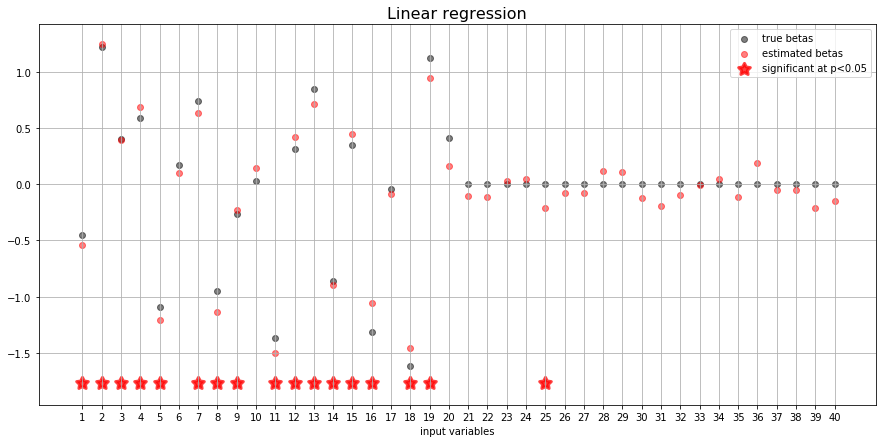

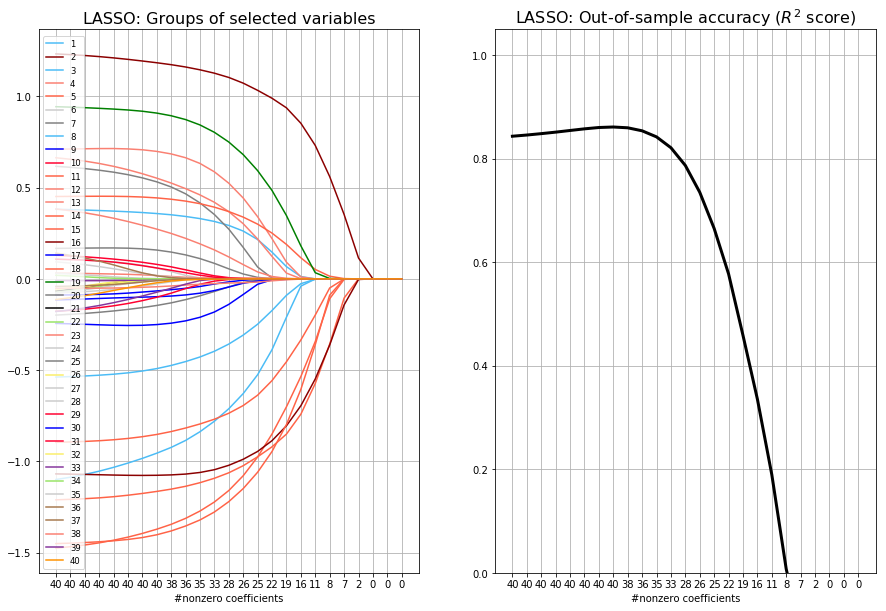

In [74]:
# dataset: 20/40 variables relevant, linear ground truth, some noise
rs = np.random.RandomState(1)
n_samples = 100
n_feat = 40
n_feat_relevant = 20
epsilon = rs.randn(n_samples)
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)
y = (true_coefs * X).sum(axis=1) + epsilon

# ordinary least squares
model = OLS(y, X)
res = model.fit()
lr_coefs = res.params
lr_pvalues = res.pvalues

# compute Lasso regularization paths
C_grid = np.logspace(-2, 0.5, 25)
coef_list, acc_list, nonzero_list = compute_Lasso_regpath(X, y, C_grid)

plot_lr(true_coefs, lr.coef_, lr_pvalues)
plot_regr_paths(coef_list, acc_list, nonzero_list, C_grid)

alpha: 0.0100 acc: 0.95 active_coefs: 40
alpha: 0.0127 acc: 0.95 active_coefs: 40
alpha: 0.0162 acc: 0.95 active_coefs: 40
alpha: 0.0205 acc: 0.95 active_coefs: 40
alpha: 0.0261 acc: 0.96 active_coefs: 40
alpha: 0.0332 acc: 0.96 active_coefs: 40
alpha: 0.0422 acc: 0.96 active_coefs: 40
alpha: 0.0536 acc: 0.96 active_coefs: 40
alpha: 0.0681 acc: 0.96 active_coefs: 38
alpha: 0.0866 acc: 0.96 active_coefs: 38
alpha: 0.1101 acc: 0.95 active_coefs: 37
alpha: 0.1399 acc: 0.93 active_coefs: 37
alpha: 0.1778 acc: 0.90 active_coefs: 34
alpha: 0.2260 acc: 0.86 active_coefs: 33
alpha: 0.2873 acc: 0.81 active_coefs: 31
alpha: 0.3652 acc: 0.75 active_coefs: 29
alpha: 0.4642 acc: 0.68 active_coefs: 28
alpha: 0.5900 acc: 0.58 active_coefs: 26
alpha: 0.7499 acc: 0.43 active_coefs: 23
alpha: 0.9532 acc: 0.22 active_coefs: 18
alpha: 1.2115 acc: -0.06 active_coefs: 14
alpha: 1.5399 acc: -0.25 active_coefs: 10
alpha: 1.9573 acc: -0.36 active_coefs: 5
alpha: 2.4879 acc: -0.45 active_coefs: 1
alpha: 3.1623 

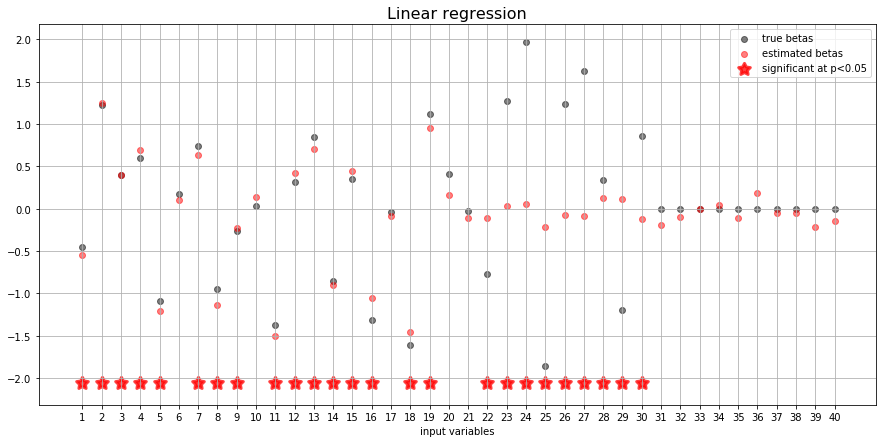

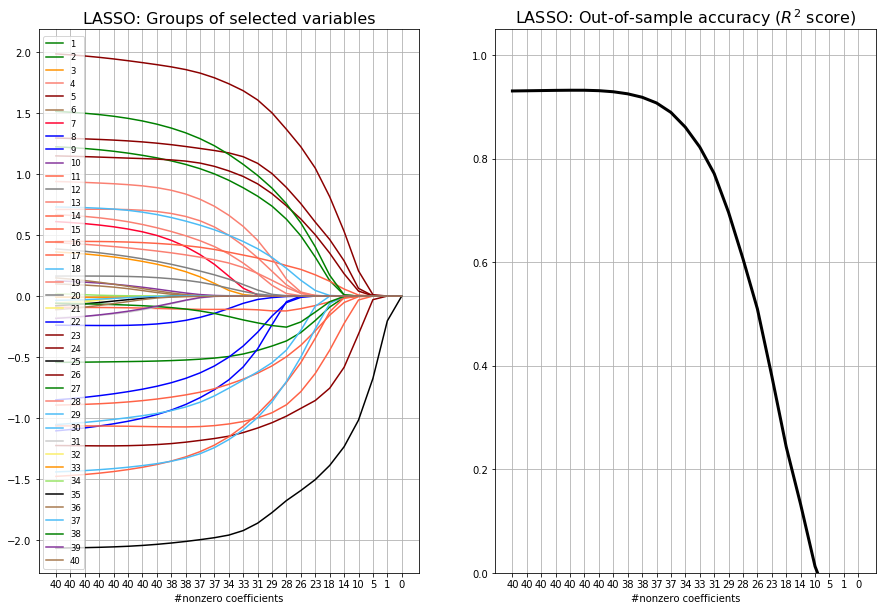

In [75]:
# dataset: 30/40 variables relevant, linear ground truth, some noise
rs = np.random.RandomState(1)
n_samples = 100
n_feat = 40
n_feat_relevant = 30
epsilon = rs.randn(n_samples)
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)
y = (true_coefs * X).sum(axis=1) + epsilon

# ordinary least squares
model = OLS(y, X)
res = model.fit()
lr_coefs = res.params
lr_pvalues = res.pvalues

# compute Lasso regularization paths
C_grid = np.logspace(-2, 0.5, 25)
coef_list, acc_list, nonzero_list = compute_Lasso_regpath(X, y, C_grid)

plot_lr(true_coefs, lr.coef_, lr_pvalues)
plot_regr_paths(coef_list, acc_list, nonzero_list, C_grid)

alpha: 0.0100 acc: 0.97 active_coefs: 40
alpha: 0.0127 acc: 0.97 active_coefs: 40
alpha: 0.0162 acc: 0.97 active_coefs: 40
alpha: 0.0205 acc: 0.97 active_coefs: 40
alpha: 0.0261 acc: 0.97 active_coefs: 40
alpha: 0.0332 acc: 0.98 active_coefs: 40
alpha: 0.0422 acc: 0.98 active_coefs: 40
alpha: 0.0536 acc: 0.98 active_coefs: 40
alpha: 0.0681 acc: 0.98 active_coefs: 40
alpha: 0.0866 acc: 0.97 active_coefs: 40
alpha: 0.1101 acc: 0.96 active_coefs: 40
alpha: 0.1399 acc: 0.94 active_coefs: 40
alpha: 0.1778 acc: 0.92 active_coefs: 40
alpha: 0.2260 acc: 0.88 active_coefs: 38
alpha: 0.2873 acc: 0.82 active_coefs: 36
alpha: 0.3652 acc: 0.75 active_coefs: 36
alpha: 0.4642 acc: 0.68 active_coefs: 33
alpha: 0.5900 acc: 0.59 active_coefs: 30
alpha: 0.7499 acc: 0.47 active_coefs: 29
alpha: 0.9532 acc: 0.30 active_coefs: 21
alpha: 1.2115 acc: 0.09 active_coefs: 17
alpha: 1.5399 acc: -0.11 active_coefs: 14
alpha: 1.9573 acc: -0.25 active_coefs: 8
alpha: 2.4879 acc: -0.31 active_coefs: 4
alpha: 3.1623 a

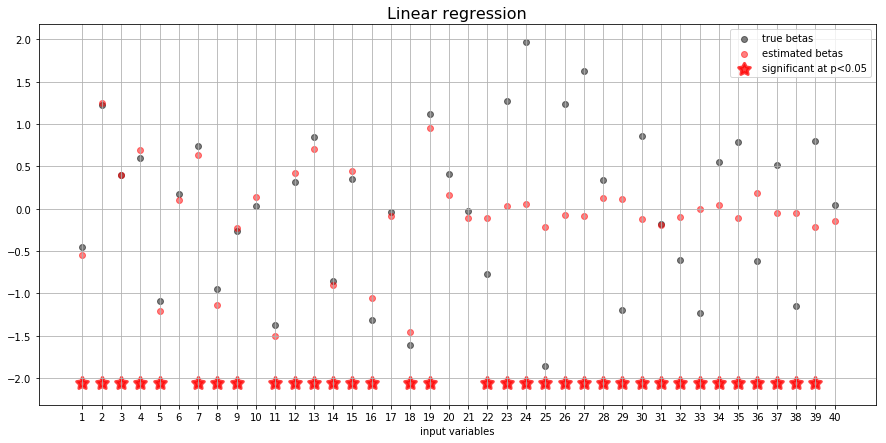

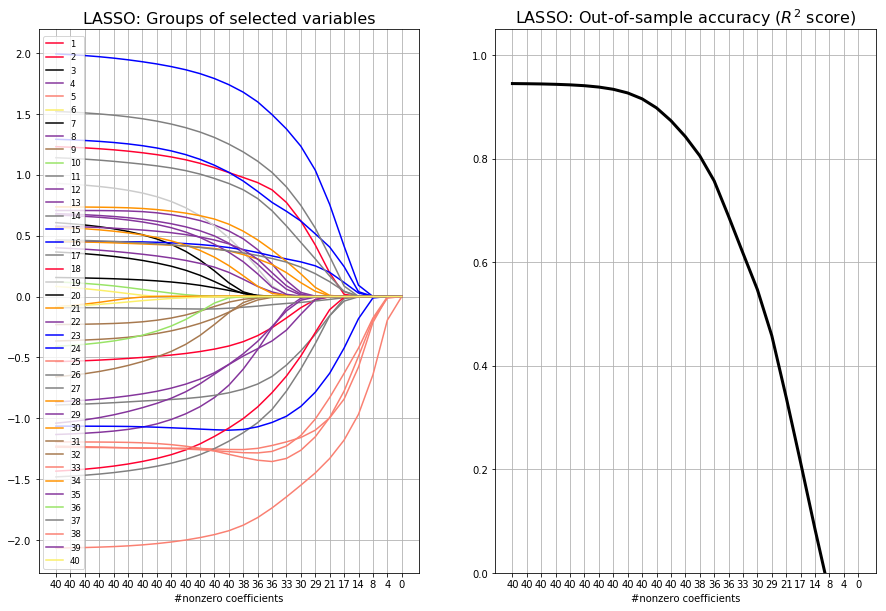

In [78]:
# dataset: 40/40 variables relevant, linear ground truth, some noise
rs = np.random.RandomState(1)
n_samples = 100
n_feat = 40
n_feat_relevant = 40
epsilon = rs.randn(n_samples)
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)
y = (true_coefs * X).sum(axis=1) + epsilon

# ordinary least squares
model = OLS(y, X)
res = model.fit()
lr_coefs = res.params
lr_pvalues = res.pvalues

# compute Lasso regularization paths
C_grid = np.logspace(-2, 0.5, 25)
coef_list, acc_list, nonzero_list = compute_Lasso_regpath(X, y, C_grid)

# plotting
plot_lr(true_coefs, lr.coef_, lr_pvalues)
plot_regr_paths(coef_list, acc_list, nonzero_list, C_grid)



# __1000 samples, 40 variables, error = N(0, 1)__

alpha: 0.0100 acc: 0.93 active_coefs: 40
alpha: 0.0127 acc: 0.93 active_coefs: 40
alpha: 0.0162 acc: 0.94 active_coefs: 40
alpha: 0.0205 acc: 0.94 active_coefs: 40
alpha: 0.0261 acc: 0.94 active_coefs: 38
alpha: 0.0332 acc: 0.94 active_coefs: 36
alpha: 0.0422 acc: 0.94 active_coefs: 28
alpha: 0.0536 acc: 0.94 active_coefs: 20
alpha: 0.0681 acc: 0.93 active_coefs: 16
alpha: 0.0866 acc: 0.93 active_coefs: 12
alpha: 0.1101 acc: 0.93 active_coefs: 11
alpha: 0.1399 acc: 0.92 active_coefs: 10
alpha: 0.1778 acc: 0.91 active_coefs: 10
alpha: 0.2260 acc: 0.90 active_coefs: 9
alpha: 0.2873 acc: 0.88 active_coefs: 8
alpha: 0.3652 acc: 0.86 active_coefs: 8
alpha: 0.4642 acc: 0.81 active_coefs: 8
alpha: 0.5900 acc: 0.75 active_coefs: 7
alpha: 0.7499 acc: 0.67 active_coefs: 5
alpha: 0.9532 acc: 0.56 active_coefs: 4
alpha: 1.2115 acc: 0.41 active_coefs: 3
alpha: 1.5399 acc: 0.19 active_coefs: 3
alpha: 1.9573 acc: 0.09 active_coefs: 1
alpha: 2.4879 acc: -0.00 active_coefs: 0
alpha: 3.1623 acc: -0.00 a

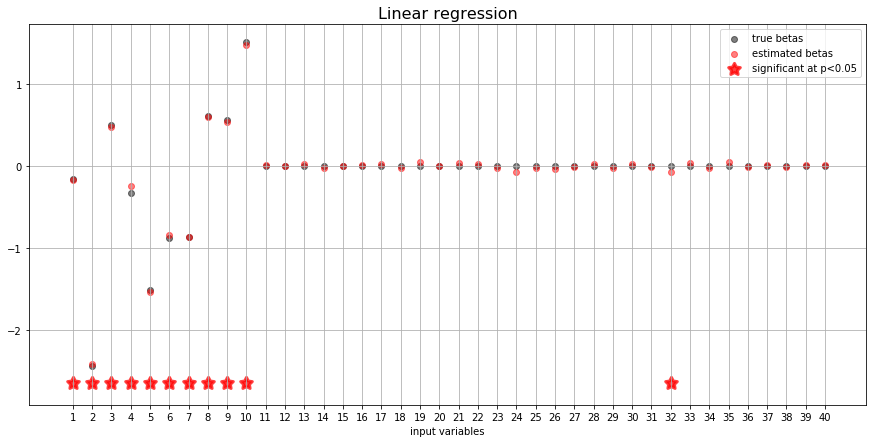

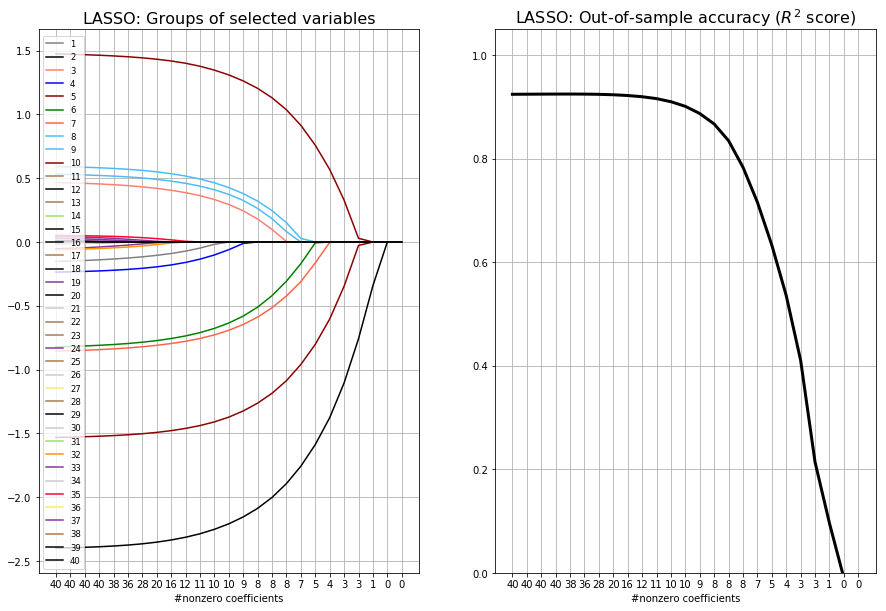

In [79]:
# dataset: 10/40 variables relevant, linear ground truth, some noise
rs = np.random.RandomState(1)
n_samples = 1000
n_feat = 40
n_feat_relevant = 10
epsilon = rs.randn(n_samples)
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)
y = (true_coefs * X).sum(axis=1) + epsilon

# ordinary least squares
model = OLS(y, X)
res = model.fit()
lr_coefs = res.params
lr_pvalues = res.pvalues

# compute Lasso regularization paths
C_grid = np.logspace(-2, 0.5, 25)
coef_list, acc_list, nonzero_list = compute_Lasso_regpath(X, y, C_grid)

# plotting
plot_lr(true_coefs, lr_coefs, lr_pvalues)
plot_regr_paths(coef_list, acc_list, nonzero_list, C_grid)

alpha: 0.0100 acc: 0.96 active_coefs: 40
alpha: 0.0127 acc: 0.96 active_coefs: 40
alpha: 0.0162 acc: 0.97 active_coefs: 40
alpha: 0.0205 acc: 0.97 active_coefs: 40
alpha: 0.0261 acc: 0.97 active_coefs: 38
alpha: 0.0332 acc: 0.97 active_coefs: 37
alpha: 0.0422 acc: 0.97 active_coefs: 35
alpha: 0.0536 acc: 0.97 active_coefs: 29
alpha: 0.0681 acc: 0.97 active_coefs: 24
alpha: 0.0866 acc: 0.96 active_coefs: 22
alpha: 0.1101 acc: 0.96 active_coefs: 21
alpha: 0.1399 acc: 0.96 active_coefs: 21
alpha: 0.1778 acc: 0.95 active_coefs: 19
alpha: 0.2260 acc: 0.94 active_coefs: 19
alpha: 0.2873 acc: 0.93 active_coefs: 18
alpha: 0.3652 acc: 0.90 active_coefs: 17
alpha: 0.4642 acc: 0.86 active_coefs: 17
alpha: 0.5900 acc: 0.81 active_coefs: 17
alpha: 0.7499 acc: 0.73 active_coefs: 12
alpha: 0.9532 acc: 0.61 active_coefs: 11
alpha: 1.2115 acc: 0.43 active_coefs: 10
alpha: 1.5399 acc: 0.19 active_coefs: 6
alpha: 1.9573 acc: 0.08 active_coefs: 1
alpha: 2.4879 acc: -0.00 active_coefs: 1
alpha: 3.1623 acc:

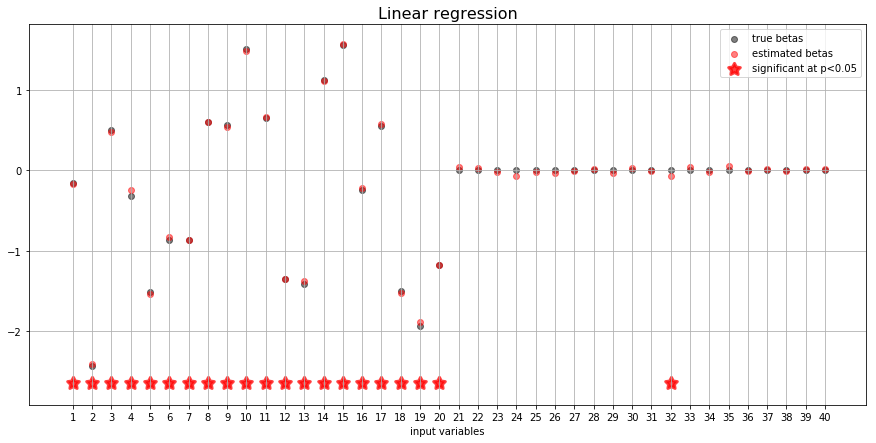

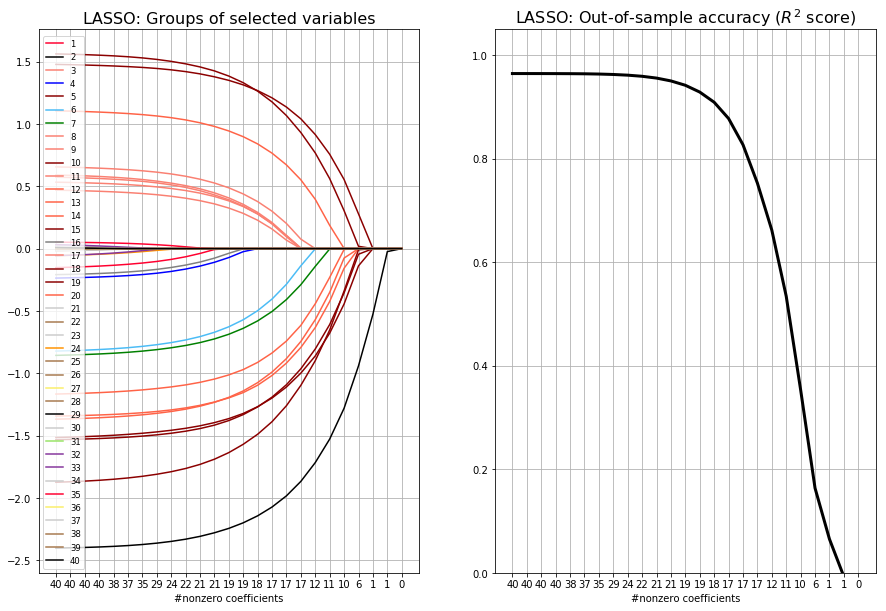

In [80]:
# dataset: 20/40 variables relevant, linear ground truth, some noise
rs = np.random.RandomState(1)
n_samples = 1000
n_feat = 40
n_feat_relevant = 20
epsilon = rs.randn(n_samples)
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)
y = (true_coefs * X).sum(axis=1) + epsilon

# ordinary least squares
model = OLS(y, X)
res = model.fit()
lr_coefs = res.params
lr_pvalues = res.pvalues

# compute Lasso regularization paths
C_grid = np.logspace(-2, 0.5, 25)
coef_list, acc_list, nonzero_list = compute_Lasso_regpath(X, y, C_grid)

# plotting
plot_lr(true_coefs, lr_coefs, lr_pvalues)
plot_regr_paths(coef_list, acc_list, nonzero_list, C_grid)

alpha: 0.0100 acc: 0.97 active_coefs: 40
alpha: 0.0127 acc: 0.97 active_coefs: 40
alpha: 0.0162 acc: 0.97 active_coefs: 40
alpha: 0.0205 acc: 0.97 active_coefs: 40
alpha: 0.0261 acc: 0.97 active_coefs: 40
alpha: 0.0332 acc: 0.97 active_coefs: 39
alpha: 0.0422 acc: 0.97 active_coefs: 37
alpha: 0.0536 acc: 0.97 active_coefs: 35
alpha: 0.0681 acc: 0.97 active_coefs: 32
alpha: 0.0866 acc: 0.97 active_coefs: 31
alpha: 0.1101 acc: 0.97 active_coefs: 30
alpha: 0.1399 acc: 0.96 active_coefs: 30
alpha: 0.1778 acc: 0.95 active_coefs: 28
alpha: 0.2260 acc: 0.94 active_coefs: 28
alpha: 0.2873 acc: 0.92 active_coefs: 26
alpha: 0.3652 acc: 0.90 active_coefs: 24
alpha: 0.4642 acc: 0.85 active_coefs: 23
alpha: 0.5900 acc: 0.80 active_coefs: 19
alpha: 0.7499 acc: 0.72 active_coefs: 15
alpha: 0.9532 acc: 0.62 active_coefs: 13
alpha: 1.2115 acc: 0.44 active_coefs: 12
alpha: 1.5399 acc: 0.23 active_coefs: 7
alpha: 1.9573 acc: 0.10 active_coefs: 3
alpha: 2.4879 acc: 0.01 active_coefs: 1
alpha: 3.1623 acc: 

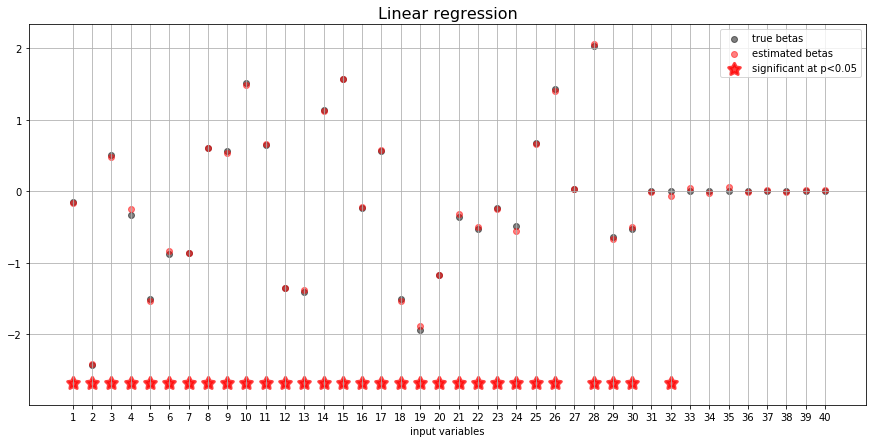

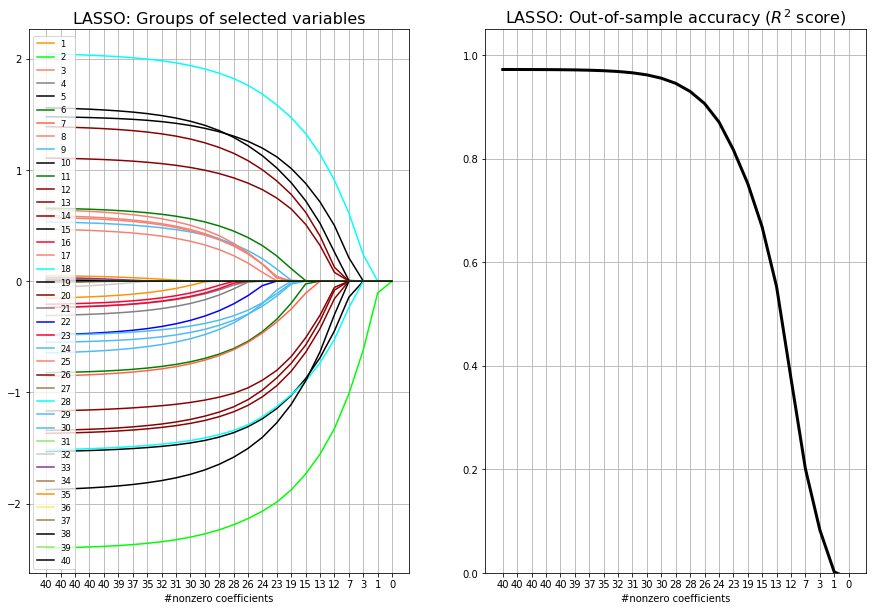

In [81]:
# dataset: 30/40 variables relevant, linear ground truth, some noise
rs = np.random.RandomState(1)
n_samples = 1000
n_feat = 40
n_feat_relevant = 30
epsilon = rs.randn(n_samples)
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)
y = (true_coefs * X).sum(axis=1) + epsilon

# ordinary least squares
model = OLS(y, X)
res = model.fit()
lr_coefs = res.params
lr_pvalues = res.pvalues

# compute Lasso regularization paths
C_grid = np.logspace(-2, 0.5, 25)
coef_list, acc_list, nonzero_list = compute_Lasso_regpath(X, y, C_grid)

# plotting
plot_lr(true_coefs, lr_coefs, lr_pvalues)
plot_regr_paths(coef_list, acc_list, nonzero_list, C_grid)

alpha: 0.0100 acc: 0.98 active_coefs: 40
alpha: 0.0127 acc: 0.98 active_coefs: 40
alpha: 0.0162 acc: 0.98 active_coefs: 40
alpha: 0.0205 acc: 0.98 active_coefs: 40
alpha: 0.0261 acc: 0.98 active_coefs: 40
alpha: 0.0332 acc: 0.98 active_coefs: 40
alpha: 0.0422 acc: 0.98 active_coefs: 40
alpha: 0.0536 acc: 0.98 active_coefs: 40
alpha: 0.0681 acc: 0.98 active_coefs: 39
alpha: 0.0866 acc: 0.97 active_coefs: 39
alpha: 0.1101 acc: 0.97 active_coefs: 39
alpha: 0.1399 acc: 0.96 active_coefs: 39
alpha: 0.1778 acc: 0.95 active_coefs: 39
alpha: 0.2260 acc: 0.94 active_coefs: 36
alpha: 0.2873 acc: 0.92 active_coefs: 34
alpha: 0.3652 acc: 0.89 active_coefs: 31
alpha: 0.4642 acc: 0.85 active_coefs: 29
alpha: 0.5900 acc: 0.79 active_coefs: 26
alpha: 0.7499 acc: 0.71 active_coefs: 21
alpha: 0.9532 acc: 0.61 active_coefs: 16
alpha: 1.2115 acc: 0.45 active_coefs: 15
alpha: 1.5399 acc: 0.28 active_coefs: 9
alpha: 1.9573 acc: 0.12 active_coefs: 6
alpha: 2.4879 acc: 0.01 active_coefs: 2
alpha: 3.1623 acc: 

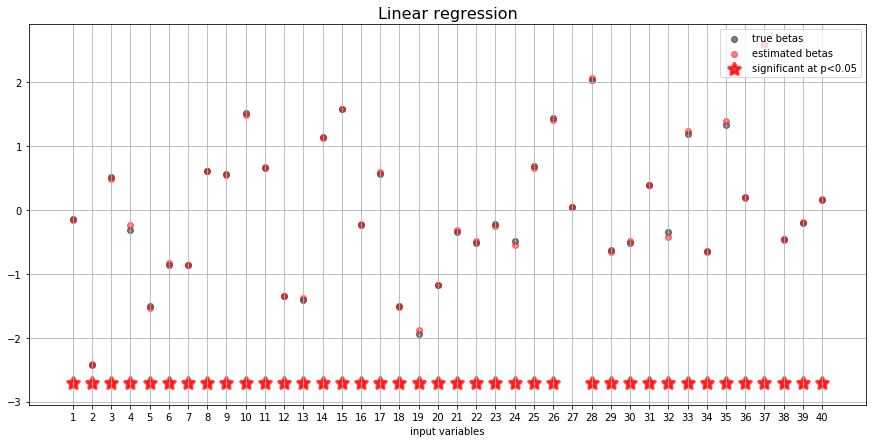

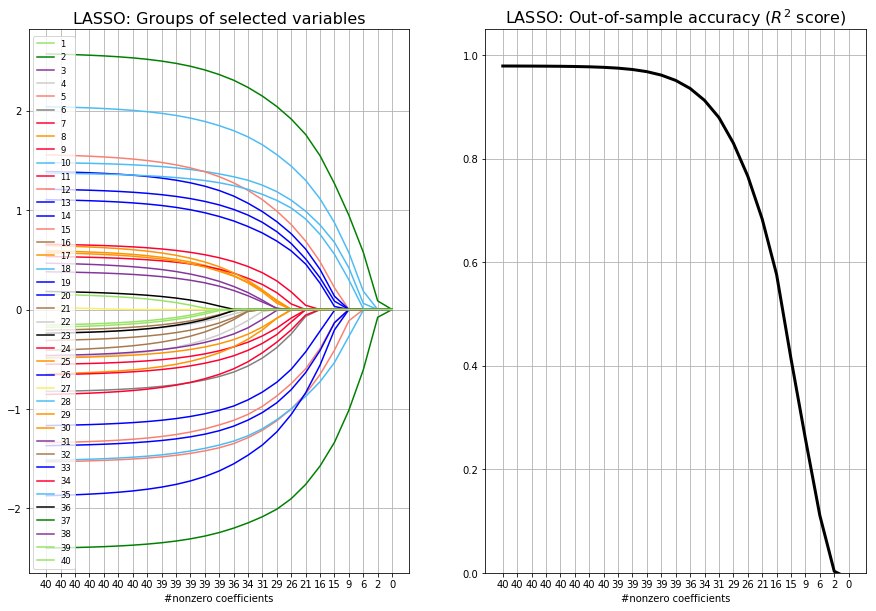

In [82]:
# dataset: 40/40 variables relevant, linear ground truth, some noise
rs = np.random.RandomState(1)
n_samples = 1000
n_feat = 40
n_feat_relevant = 40
epsilon = rs.randn(n_samples)
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)
y = (true_coefs * X).sum(axis=1) + epsilon

# ordinary least squares
model = OLS(y, X)
res = model.fit()
lr_coefs = res.params
lr_pvalues = res.pvalues

# compute Lasso regularization paths
C_grid = np.logspace(-2, 0.5, 25)
coef_list, acc_list, nonzero_list = compute_Lasso_regpath(X, y, C_grid)

# plotting
plot_lr(true_coefs, lr_coefs, lr_pvalues)
plot_regr_paths(coef_list, acc_list, nonzero_list, C_grid)

# __100 samples, 40 variables, error = none__

alpha: 0.0010 acc: 1.00 active_coefs: 10
alpha: 0.0014 acc: 1.00 active_coefs: 10
alpha: 0.0020 acc: 1.00 active_coefs: 10
alpha: 0.0027 acc: 1.00 active_coefs: 10
alpha: 0.0038 acc: 1.00 active_coefs: 10
alpha: 0.0054 acc: 1.00 active_coefs: 10
alpha: 0.0075 acc: 1.00 active_coefs: 10
alpha: 0.0105 acc: 1.00 active_coefs: 10
alpha: 0.0147 acc: 1.00 active_coefs: 10
alpha: 0.0205 acc: 1.00 active_coefs: 10
alpha: 0.0287 acc: 1.00 active_coefs: 10
alpha: 0.0402 acc: 1.00 active_coefs: 10
alpha: 0.0562 acc: 1.00 active_coefs: 10
alpha: 0.0787 acc: 0.99 active_coefs: 10
alpha: 0.1101 acc: 0.99 active_coefs: 10
alpha: 0.1540 acc: 0.98 active_coefs: 10
alpha: 0.2154 acc: 0.96 active_coefs: 10
alpha: 0.3014 acc: 0.93 active_coefs: 10
alpha: 0.4217 acc: 0.89 active_coefs: 8
alpha: 0.5900 acc: 0.80 active_coefs: 7
alpha: 0.8254 acc: 0.68 active_coefs: 6
alpha: 1.1548 acc: 0.47 active_coefs: 5
alpha: 1.6156 acc: 0.18 active_coefs: 3
alpha: 2.2603 acc: -0.05 active_coefs: 1
alpha: 3.1623 acc: -0

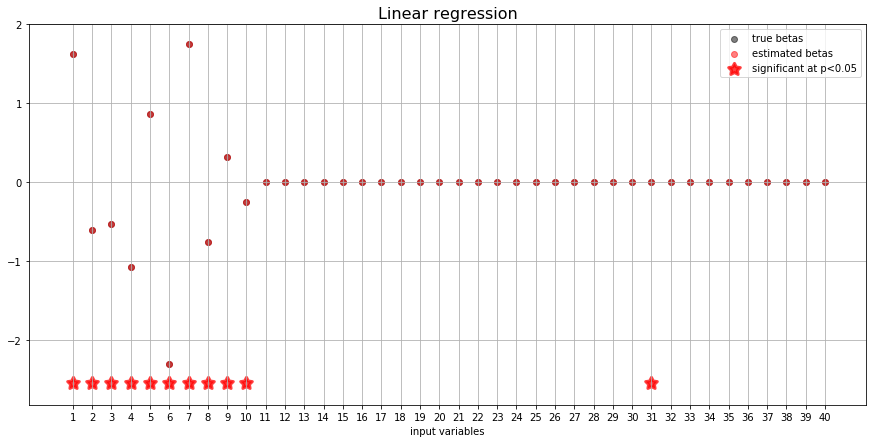

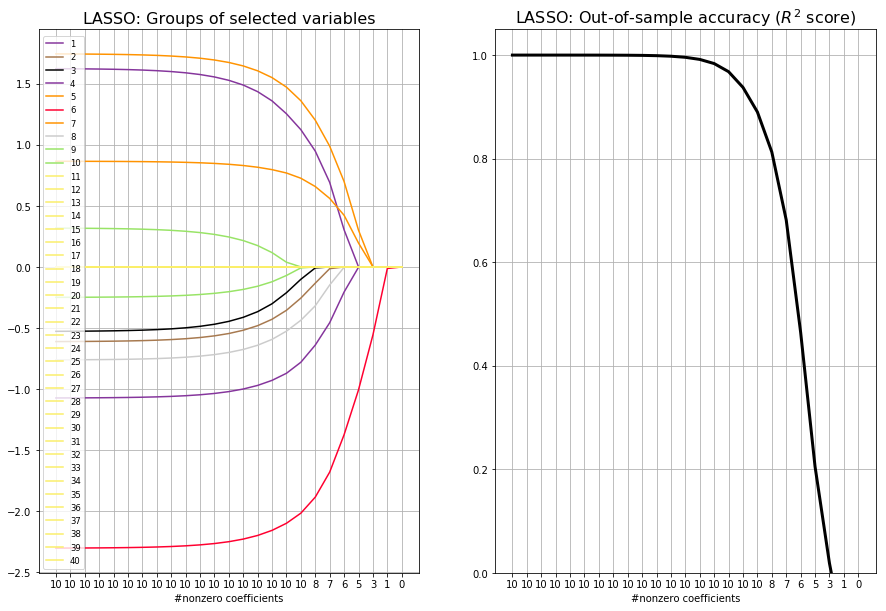

In [83]:
# dataset: 10/40 variables relevant, linear ground truth, some noise
rs = np.random.RandomState(1)
n_samples = 100
n_feat = 40
n_feat_relevant = 10
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)
y = (true_coefs * X).sum(axis=1)

# ordinary least squares
model = OLS(y, X)
res = model.fit()
lr_coefs = res.params
lr_pvalues = res.pvalues

# compute Lasso regularization paths
C_grid = np.logspace(-3, 0.5, 25)
coef_list, acc_list, nonzero_list = compute_Lasso_regpath(X, y, C_grid)

plot_lr(true_coefs, lr_coefs, lr_pvalues)
plot_regr_paths(coef_list, acc_list, nonzero_list, C_grid)

alpha: 0.0010 acc: 1.00 active_coefs: 25
alpha: 0.0014 acc: 1.00 active_coefs: 24
alpha: 0.0020 acc: 1.00 active_coefs: 24
alpha: 0.0027 acc: 1.00 active_coefs: 24
alpha: 0.0038 acc: 1.00 active_coefs: 24
alpha: 0.0054 acc: 1.00 active_coefs: 24
alpha: 0.0075 acc: 1.00 active_coefs: 24
alpha: 0.0105 acc: 1.00 active_coefs: 24
alpha: 0.0147 acc: 1.00 active_coefs: 24
alpha: 0.0205 acc: 1.00 active_coefs: 24
alpha: 0.0287 acc: 1.00 active_coefs: 24
alpha: 0.0402 acc: 1.00 active_coefs: 22
alpha: 0.0562 acc: 1.00 active_coefs: 23
alpha: 0.0787 acc: 0.99 active_coefs: 23
alpha: 0.1101 acc: 0.98 active_coefs: 24
alpha: 0.1540 acc: 0.97 active_coefs: 24
alpha: 0.2154 acc: 0.94 active_coefs: 22
alpha: 0.3014 acc: 0.90 active_coefs: 20
alpha: 0.4217 acc: 0.83 active_coefs: 17
alpha: 0.5900 acc: 0.69 active_coefs: 14
alpha: 0.8254 acc: 0.39 active_coefs: 13
alpha: 1.1548 acc: 0.00 active_coefs: 12
alpha: 1.6156 acc: -0.69 active_coefs: 7
alpha: 2.2603 acc: -1.09 active_coefs: 2
alpha: 3.1623 ac

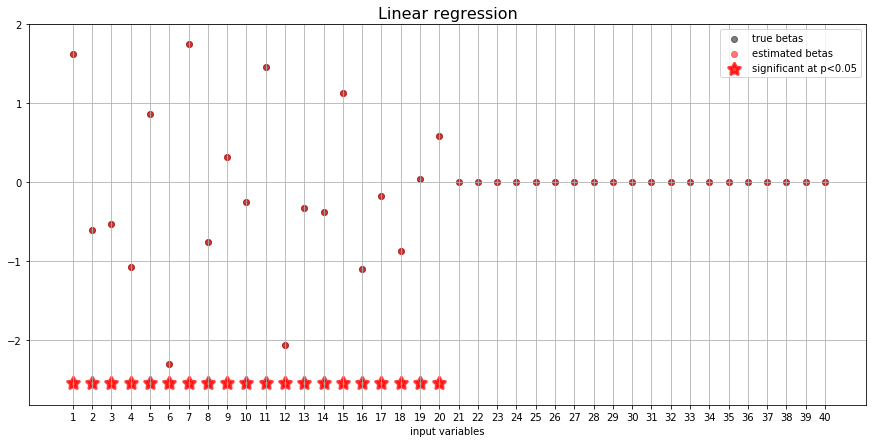

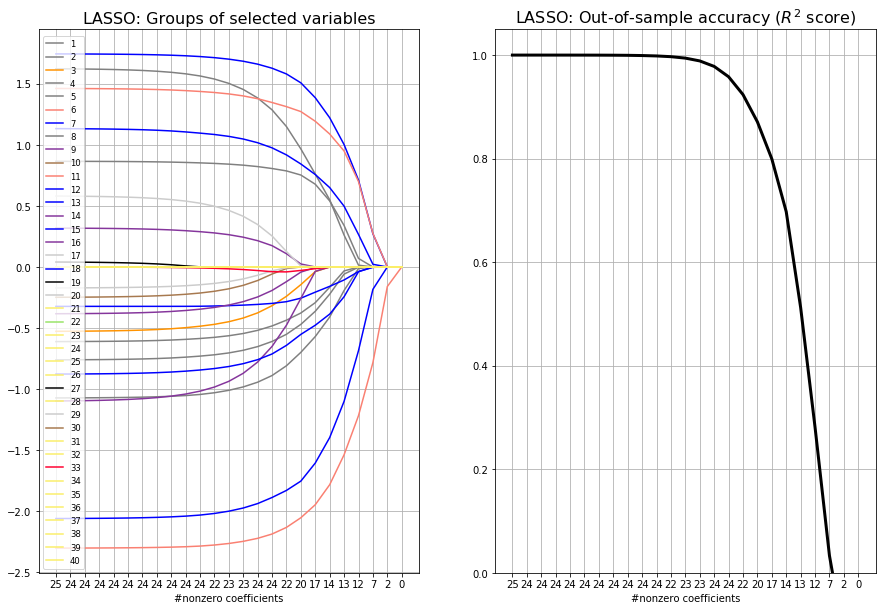

In [84]:
# dataset: 20/40 variables relevant, linear ground truth, some noise
rs = np.random.RandomState(1)
n_samples = 100
n_feat = 40
n_feat_relevant = 20
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)
y = (true_coefs * X).sum(axis=1)

# ordinary least squares
model = OLS(y, X)
res = model.fit()
lr_coefs = res.params
lr_pvalues = res.pvalues

# compute Lasso regularization paths
C_grid = np.logspace(-3, 0.5, 25)
coef_list, acc_list, nonzero_list = compute_Lasso_regpath(X, y, C_grid)

plot_lr(true_coefs, lr_coefs, lr_pvalues)
plot_regr_paths(coef_list, acc_list, nonzero_list, C_grid)

alpha: 0.0010 acc: 1.00 active_coefs: 38
alpha: 0.0014 acc: 1.00 active_coefs: 38
alpha: 0.0020 acc: 1.00 active_coefs: 38
alpha: 0.0027 acc: 1.00 active_coefs: 38
alpha: 0.0038 acc: 1.00 active_coefs: 38
alpha: 0.0054 acc: 1.00 active_coefs: 38
alpha: 0.0075 acc: 1.00 active_coefs: 38
alpha: 0.0105 acc: 1.00 active_coefs: 38
alpha: 0.0147 acc: 1.00 active_coefs: 38
alpha: 0.0205 acc: 1.00 active_coefs: 38
alpha: 0.0287 acc: 0.99 active_coefs: 38
alpha: 0.0402 acc: 0.99 active_coefs: 38
alpha: 0.0562 acc: 0.97 active_coefs: 38
alpha: 0.0787 acc: 0.95 active_coefs: 38
alpha: 0.1101 acc: 0.91 active_coefs: 37
alpha: 0.1540 acc: 0.83 active_coefs: 35
alpha: 0.2154 acc: 0.69 active_coefs: 35
alpha: 0.3014 acc: 0.50 active_coefs: 34
alpha: 0.4217 acc: 0.23 active_coefs: 28
alpha: 0.5900 acc: -0.25 active_coefs: 23
alpha: 0.8254 acc: -0.74 active_coefs: 20
alpha: 1.1548 acc: -0.97 active_coefs: 17
alpha: 1.6156 acc: -1.18 active_coefs: 9
alpha: 2.2603 acc: -1.40 active_coefs: 2
alpha: 3.1623

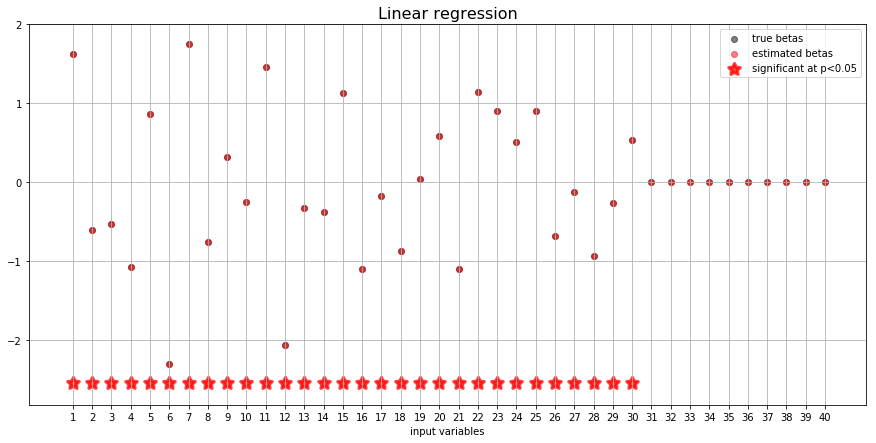

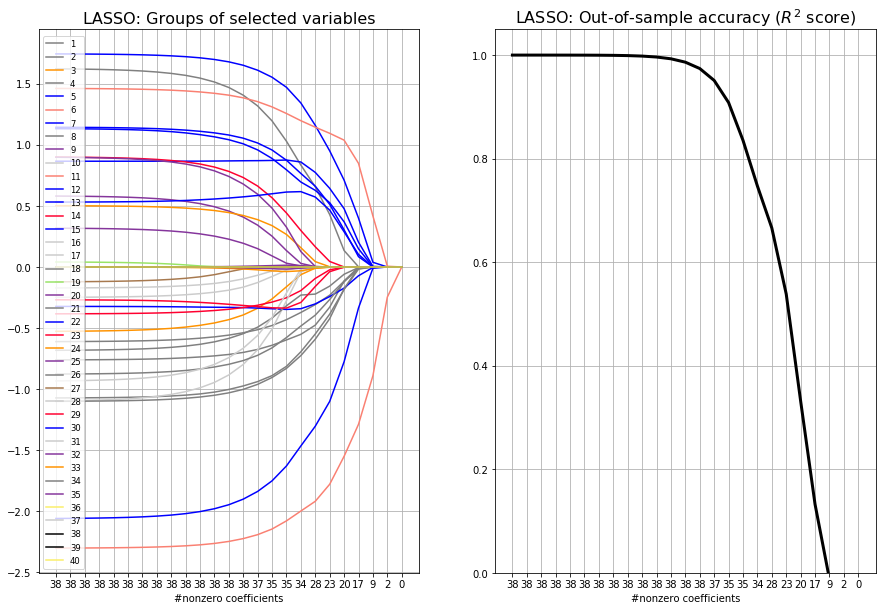

In [85]:
# dataset: 30/40 variables relevant, linear ground truth, some noise
rs = np.random.RandomState(1)
n_samples = 100
n_feat = 40
n_feat_relevant = 30
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)
y = (true_coefs * X).sum(axis=1)

# ordinary least squares
model = OLS(y, X)
res = model.fit()
lr_coefs = res.params
lr_pvalues = res.pvalues

# compute Lasso regularization paths
C_grid = np.logspace(-3, 0.5, 25)
coef_list, acc_list, nonzero_list = compute_Lasso_regpath(X, y, C_grid)

plot_lr(true_coefs, lr_coefs, lr_pvalues)
plot_regr_paths(coef_list, acc_list, nonzero_list, C_grid)

alpha: 0.0010 acc: 1.00 active_coefs: 40
alpha: 0.0014 acc: 1.00 active_coefs: 40
alpha: 0.0020 acc: 1.00 active_coefs: 40
alpha: 0.0027 acc: 1.00 active_coefs: 40
alpha: 0.0038 acc: 1.00 active_coefs: 40
alpha: 0.0054 acc: 1.00 active_coefs: 40
alpha: 0.0075 acc: 1.00 active_coefs: 40
alpha: 0.0105 acc: 1.00 active_coefs: 40
alpha: 0.0147 acc: 1.00 active_coefs: 40
alpha: 0.0205 acc: 1.00 active_coefs: 40
alpha: 0.0287 acc: 0.99 active_coefs: 40
alpha: 0.0402 acc: 0.98 active_coefs: 40
alpha: 0.0562 acc: 0.97 active_coefs: 40
alpha: 0.0787 acc: 0.94 active_coefs: 40
alpha: 0.1101 acc: 0.88 active_coefs: 40
alpha: 0.1540 acc: 0.81 active_coefs: 40
alpha: 0.2154 acc: 0.68 active_coefs: 38
alpha: 0.3014 acc: 0.53 active_coefs: 37
alpha: 0.4217 acc: 0.37 active_coefs: 35
alpha: 0.5900 acc: 0.13 active_coefs: 31
alpha: 0.8254 acc: -0.17 active_coefs: 27
alpha: 1.1548 acc: -0.21 active_coefs: 23
alpha: 1.6156 acc: -0.30 active_coefs: 11
alpha: 2.2603 acc: -0.51 active_coefs: 3
alpha: 3.1623

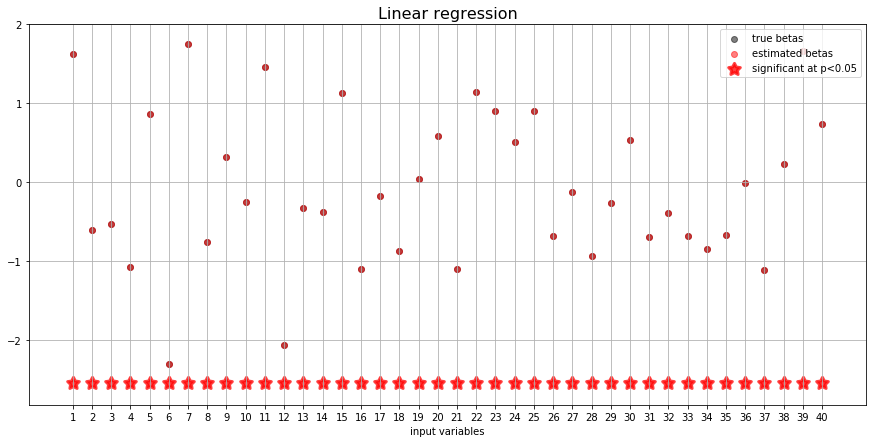

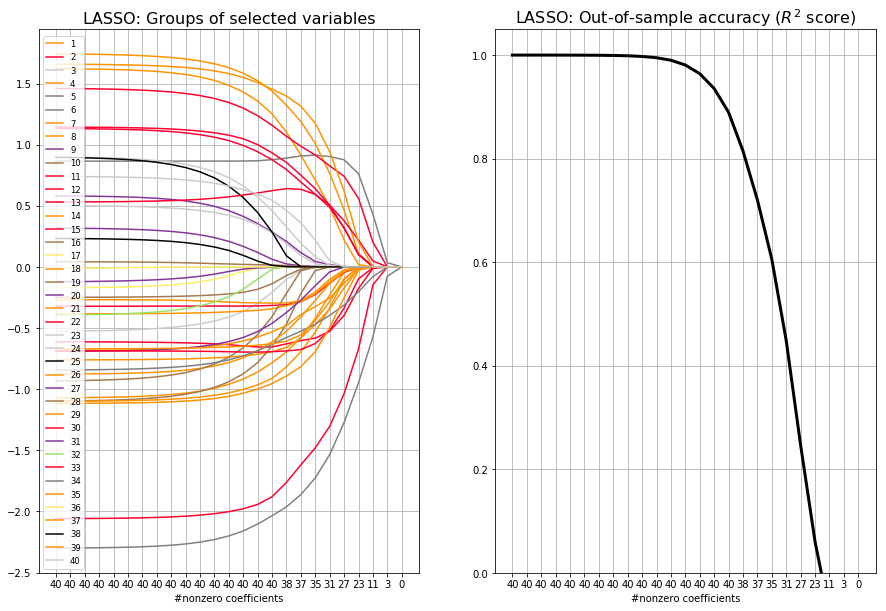

In [86]:
# dataset: 40/40 variables relevant, linear ground truth, some noise
rs = np.random.RandomState(1)
n_samples = 100
n_feat = 40
n_feat_relevant = 40
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)
y = (true_coefs * X).sum(axis=1)

# ordinary least squares
model = OLS(y, X)
res = model.fit()
lr_coefs = res.params
lr_pvalues = res.pvalues

# compute Lasso regularization paths
C_grid = np.logspace(-3, 0.5, 25)
coef_list, acc_list, nonzero_list = compute_Lasso_regpath(X, y, C_grid)

plot_lr(true_coefs, lr_coefs, lr_pvalues)
plot_regr_paths(coef_list, acc_list, nonzero_list, C_grid)

# __Pathological cases with diverging ground-truth model (abs, log, exp, sqrt, 1/x): 1000 samples, 40 variables, error = N(0,1)__

alpha: 0.0562 acc: 0.47 active_coefs: 38
alpha: 0.0649 acc: 0.47 active_coefs: 38
alpha: 0.0750 acc: 0.47 active_coefs: 32
alpha: 0.0866 acc: 0.48 active_coefs: 28
alpha: 0.1000 acc: 0.48 active_coefs: 20
alpha: 0.1155 acc: 0.48 active_coefs: 16
alpha: 0.1334 acc: 0.48 active_coefs: 13
alpha: 0.1540 acc: 0.48 active_coefs: 8
alpha: 0.1778 acc: 0.48 active_coefs: 7
alpha: 0.2054 acc: 0.47 active_coefs: 5
alpha: 0.2371 acc: 0.47 active_coefs: 4
alpha: 0.2738 acc: 0.46 active_coefs: 4
alpha: 0.3162 acc: 0.45 active_coefs: 4
alpha: 0.3652 acc: 0.43 active_coefs: 4
alpha: 0.4217 acc: 0.41 active_coefs: 4
alpha: 0.4870 acc: 0.37 active_coefs: 4
alpha: 0.5623 acc: 0.33 active_coefs: 4
alpha: 0.6494 acc: 0.30 active_coefs: 4
alpha: 0.7499 acc: 0.27 active_coefs: 2
alpha: 0.8660 acc: 0.23 active_coefs: 2
alpha: 1.0000 acc: 0.18 active_coefs: 1
alpha: 1.1548 acc: 0.13 active_coefs: 1
alpha: 1.3335 acc: 0.05 active_coefs: 1
alpha: 1.5399 acc: -0.04 active_coefs: 1
alpha: 1.7783 acc: -0.04 active_

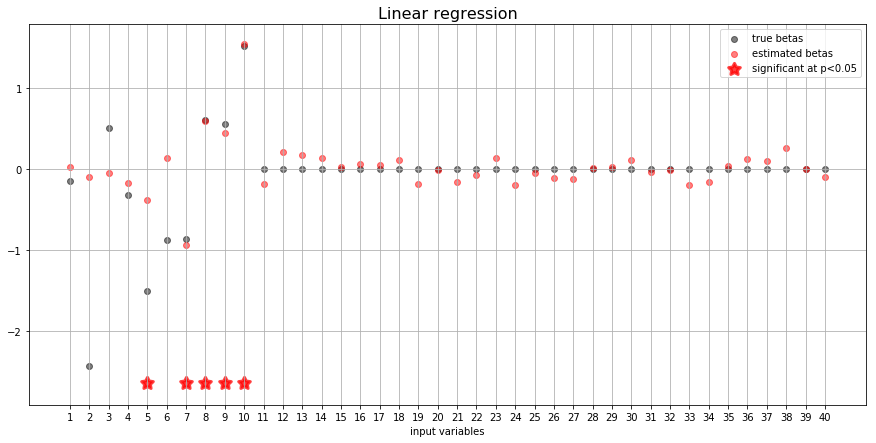

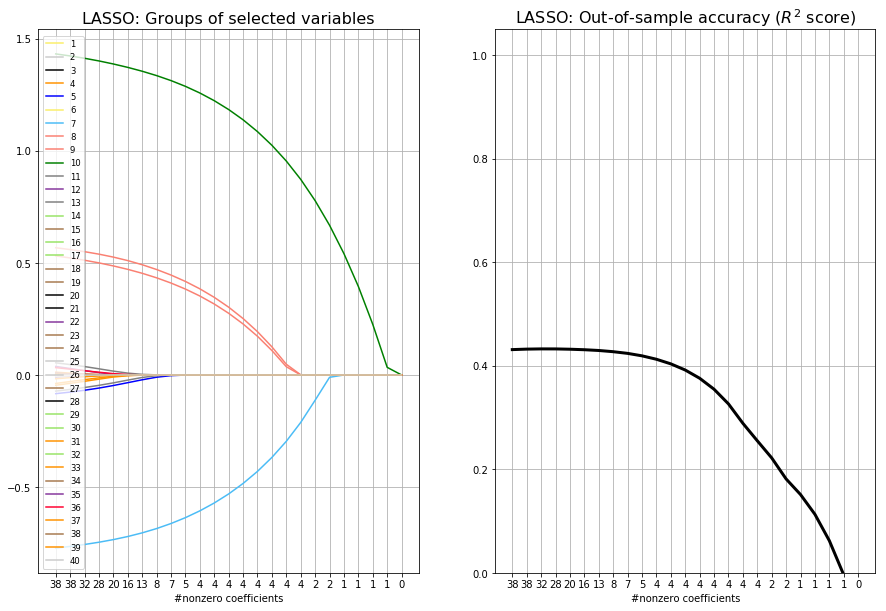

In [123]:
# abs / dataset: 10/40 relevant variables, including 5 pathological ones, linear ground truth, some noise
rs = np.random.RandomState(1)
n_samples = 1000
n_feat = 40
n_feat_relevant = 10
epsilon = rs.randn(n_samples)
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)

X_abs5 = X.copy()
X_abs5[:, 0:6] = np.abs(X_abs5[:, 0:6])  # introduce pathological transformation, NOT captured by ground-truth model
y = (true_coefs * X_abs5).sum(axis=1) + epsilon

# ordinary least squares
model = OLS(y, X)
res = model.fit()
lr_coefs = res.params
lr_pvalues = res.pvalues

# compute Lasso regularization paths
C_grid = np.logspace(-1.25, 0.25, 25)
coef_list, acc_list, nonzero_list = compute_Lasso_regpath(X, y, C_grid)

plot_lr(true_coefs, lr_coefs, lr_pvalues)
plot_regr_paths(coef_list, acc_list, nonzero_list, C_grid)

In [124]:
### observation: 1/5 path. variables are significant, the same 1/5 path. (?) variables are selected as predictive

alpha: 0.0100 acc: 0.88 active_coefs: 40
alpha: 0.0127 acc: 0.88 active_coefs: 40
alpha: 0.0162 acc: 0.88 active_coefs: 40
alpha: 0.0205 acc: 0.88 active_coefs: 40
alpha: 0.0261 acc: 0.88 active_coefs: 40
alpha: 0.0332 acc: 0.88 active_coefs: 39
alpha: 0.0422 acc: 0.88 active_coefs: 35
alpha: 0.0536 acc: 0.88 active_coefs: 29
alpha: 0.0681 acc: 0.88 active_coefs: 19
alpha: 0.0866 acc: 0.88 active_coefs: 16
alpha: 0.1101 acc: 0.87 active_coefs: 12
alpha: 0.1399 acc: 0.87 active_coefs: 10
alpha: 0.1778 acc: 0.86 active_coefs: 10
alpha: 0.2260 acc: 0.84 active_coefs: 8
alpha: 0.2873 acc: 0.82 active_coefs: 8
alpha: 0.3652 acc: 0.79 active_coefs: 8
alpha: 0.4642 acc: 0.74 active_coefs: 7
alpha: 0.5900 acc: 0.67 active_coefs: 7
alpha: 0.7499 acc: 0.58 active_coefs: 4
alpha: 0.9532 acc: 0.46 active_coefs: 4
alpha: 1.2115 acc: 0.28 active_coefs: 3
alpha: 1.5399 acc: 0.12 active_coefs: 2
alpha: 1.9573 acc: 0.00 active_coefs: 1
alpha: 2.4879 acc: -0.00 active_coefs: 0
alpha: 3.1623 acc: -0.00 a

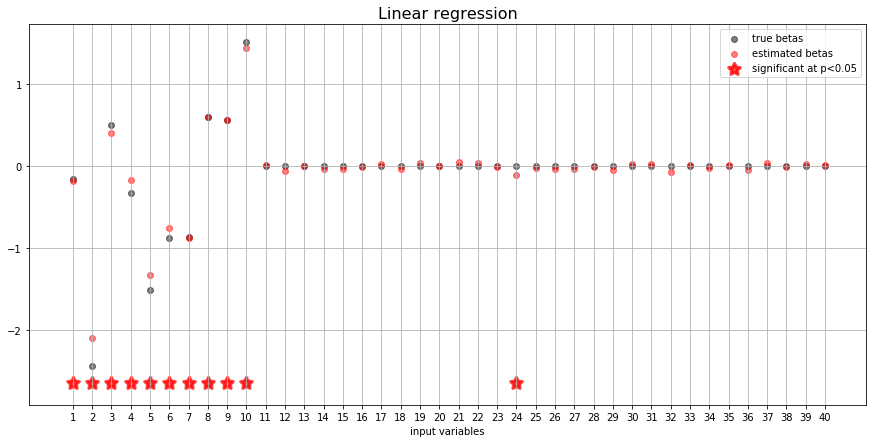

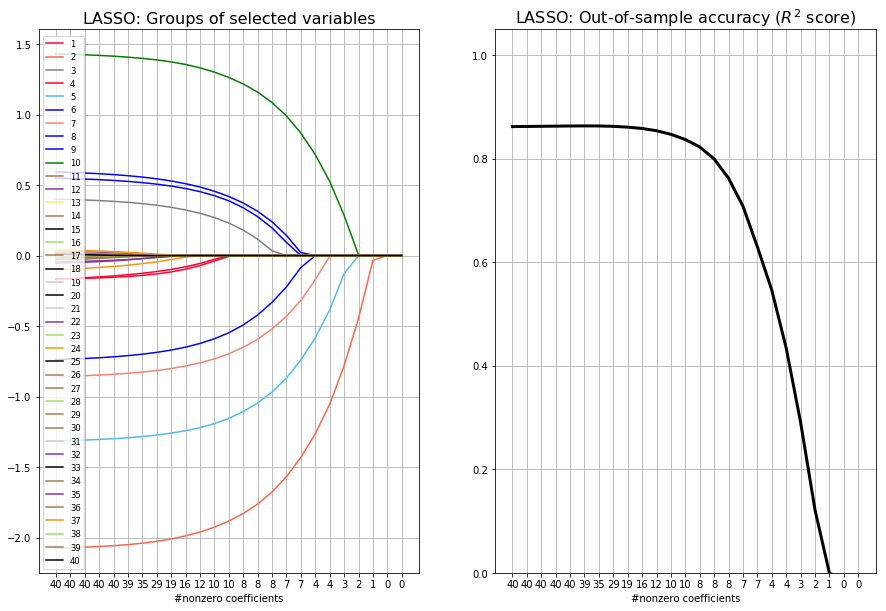

In [125]:
# square root / dataset: 10/40 relevant variables, including 5 pathological ones, linear ground truth, some noise
rs = np.random.RandomState(1)
n_samples = 1000
n_feat = 40
n_feat_relevant = 10
epsilon = rs.randn(n_samples)
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)

X_sqrt5 = X.copy()
signs = np.sign(X)
X_sqrt5[:, 0:6] = signs[:, 0:6] * np.sqrt(np.abs(X_sqrt5[:, 0:6]))  # introduce pathological transformation, NOT captured by ground-truth model
y = (true_coefs * X_sqrt5).sum(axis=1) + epsilon

# ordinary least squares
model = OLS(y, X)
res = model.fit()
lr_coefs = res.params
lr_pvalues = res.pvalues

# compute Lasso regularization paths
C_grid = np.logspace(-2, 0.5, 25)
coef_list, acc_list, nonzero_list = compute_Lasso_regpath(X, y, C_grid)

plot_lr(true_coefs, lr_coefs, lr_pvalues)
plot_regr_paths(coef_list, acc_list, nonzero_list, C_grid)

In [126]:
### observation: 5/5 path. variables are significant, the same 5/5 path. (?) variables are selected as predictive

alpha: 0.0100 acc: 0.13 active_coefs: 40
alpha: 0.0127 acc: 0.13 active_coefs: 40
alpha: 0.0162 acc: 0.13 active_coefs: 40
alpha: 0.0205 acc: 0.13 active_coefs: 40
alpha: 0.0261 acc: 0.13 active_coefs: 40
alpha: 0.0332 acc: 0.13 active_coefs: 40
alpha: 0.0422 acc: 0.13 active_coefs: 40
alpha: 0.0536 acc: 0.14 active_coefs: 40
alpha: 0.0681 acc: 0.14 active_coefs: 40
alpha: 0.0866 acc: 0.14 active_coefs: 40
alpha: 0.1101 acc: 0.14 active_coefs: 40
alpha: 0.1399 acc: 0.15 active_coefs: 38
alpha: 0.1778 acc: 0.16 active_coefs: 29
alpha: 0.2260 acc: 0.15 active_coefs: 16
alpha: 0.2873 acc: 0.15 active_coefs: 13
alpha: 0.3652 acc: 0.15 active_coefs: 8
alpha: 0.4642 acc: 0.14 active_coefs: 5
alpha: 0.5900 acc: 0.13 active_coefs: 4
alpha: 0.7499 acc: 0.12 active_coefs: 3
alpha: 0.9532 acc: 0.09 active_coefs: 2
alpha: 1.2115 acc: 0.06 active_coefs: 1
alpha: 1.5399 acc: 0.01 active_coefs: 1
alpha: 1.9573 acc: -0.00 active_coefs: 0
alpha: 2.4879 acc: -0.00 active_coefs: 0
alpha: 3.1623 acc: -0.0

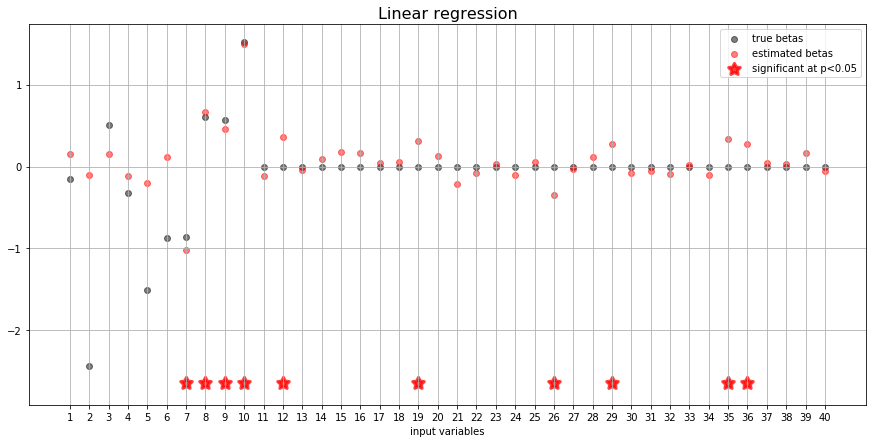

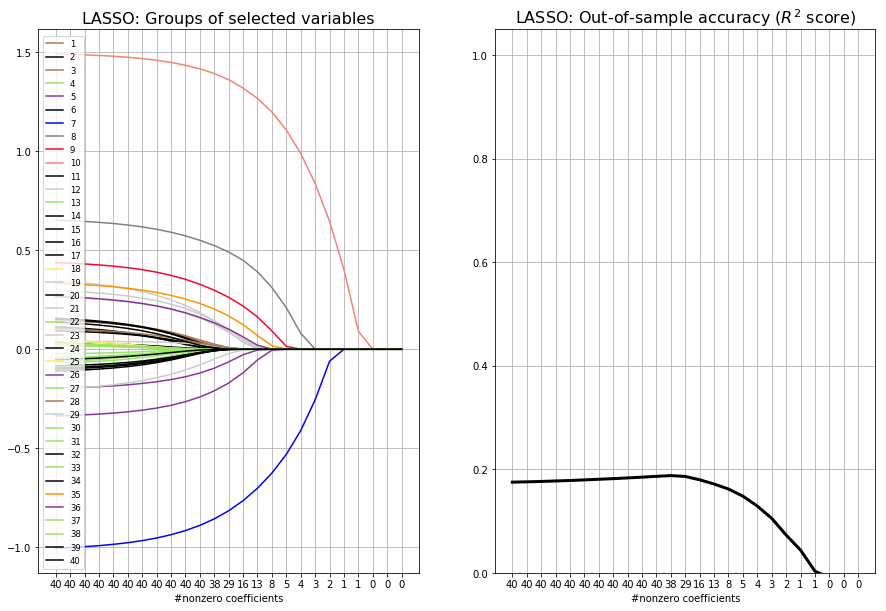

In [127]:
# logn / dataset: 10/40 relevant variables, including 5 pathological ones, linear ground truth, some noise
rs = np.random.RandomState(1)
n_samples = 1000
n_feat = 40
n_feat_relevant = 10
epsilon = rs.randn(n_samples)
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)

X_log5 = X.copy()
signs = np.sign(X)
X_log5[:, 0:6] = signs[:, 0:6] * np.log(np.abs(X_log5[:, 0:6]))  # introduce pathological transformation, NOT captured by ground-truth model
y = (true_coefs * X_log5).sum(axis=1) + epsilon

# ordinary least squares
model = OLS(y, X)
res = model.fit()
lr_coefs = res.params
lr_pvalues = res.pvalues

# compute Lasso regularization paths
C_grid = np.logspace(-2, 0.5, 25)
coef_list, acc_list, nonzero_list = compute_Lasso_regpath(X, y, C_grid)

plot_lr(true_coefs, lr_coefs, lr_pvalues)
plot_regr_paths(coef_list, acc_list, nonzero_list, C_grid)

### observation: 0/5 path. variables are significant, the same 1/5 path. variables are selected as predictive

alpha: 0.0010 acc: 0.70 active_coefs: 40
alpha: 0.0015 acc: 0.70 active_coefs: 40
alpha: 0.0022 acc: 0.70 active_coefs: 40
alpha: 0.0032 acc: 0.70 active_coefs: 40
alpha: 0.0046 acc: 0.70 active_coefs: 40
alpha: 0.0068 acc: 0.70 active_coefs: 40
alpha: 0.0100 acc: 0.70 active_coefs: 40
alpha: 0.0147 acc: 0.70 active_coefs: 40
alpha: 0.0215 acc: 0.70 active_coefs: 40
alpha: 0.0316 acc: 0.70 active_coefs: 40
alpha: 0.0464 acc: 0.71 active_coefs: 40
alpha: 0.0681 acc: 0.71 active_coefs: 40
alpha: 0.1000 acc: 0.71 active_coefs: 40
alpha: 0.1468 acc: 0.71 active_coefs: 37
alpha: 0.2154 acc: 0.72 active_coefs: 25
alpha: 0.3162 acc: 0.72 active_coefs: 15
alpha: 0.4642 acc: 0.71 active_coefs: 9
alpha: 0.6813 acc: 0.67 active_coefs: 8
alpha: 1.0000 acc: 0.62 active_coefs: 4
alpha: 1.4678 acc: 0.51 active_coefs: 4
alpha: 2.1544 acc: 0.39 active_coefs: 2
alpha: 3.1623 acc: 0.17 active_coefs: 2
alpha: 4.6416 acc: -0.00 active_coefs: 0
alpha: 6.8129 acc: -0.00 active_coefs: 0
alpha: 10.0000 acc: -0

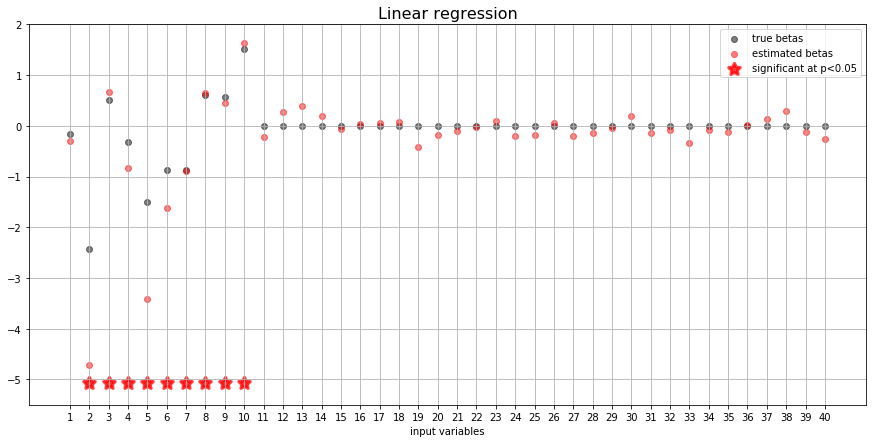

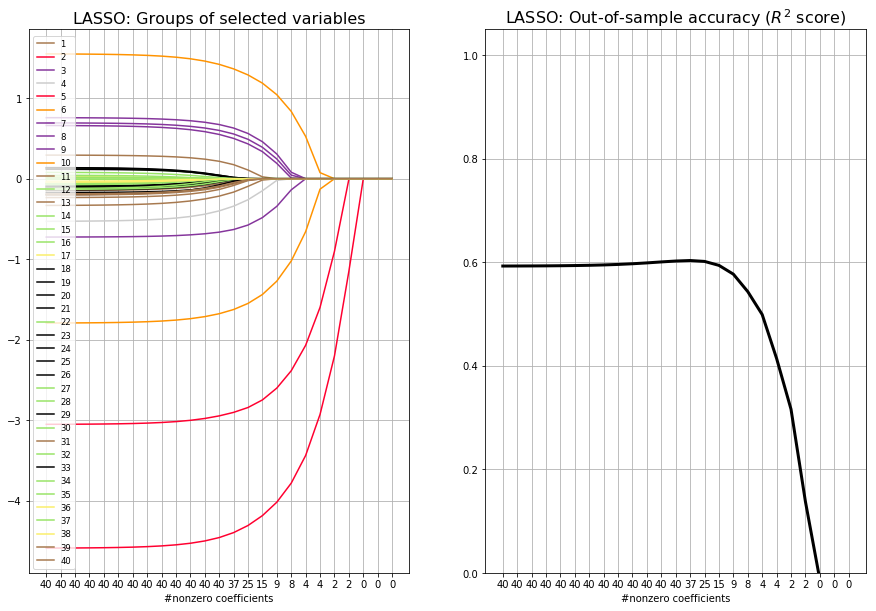

In [138]:
# exp / dataset: 10/40 relevant variables, including 5 pathological ones, linear ground truth, some noise
rs = np.random.RandomState(1)
n_samples = 1000
n_feat = 40
n_feat_relevant = 10
epsilon = rs.randn(n_samples)
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)

X_exp = X.copy()
signs = np.sign(X)
X_exp[:, 0:6] = signs[:, 0:6] * np.exp(X_exp[:, 0:6])  # introduce pathological transformation, NOT captured by ground-truth model
y = (true_coefs * X_exp).sum(axis=1) + epsilon

# ordinary least squares
model = OLS(y, X)
res = model.fit()
lr_coefs = res.params
lr_pvalues = res.pvalues

# compute Lasso regularization paths
C_grid = np.logspace(-3, 1, 25)
coef_list, acc_list, nonzero_list = compute_Lasso_regpath(X, y, C_grid)

plot_lr(true_coefs, lr_coefs, lr_pvalues)
plot_regr_paths(coef_list, acc_list, nonzero_list, C_grid)

In [ ]:
### observation: 4/5 path. variables are significant, the ?/5 path. variables are selected as predictive

alpha: 0.0100 acc: -0.13 active_coefs: 40
alpha: 0.0140 acc: -0.13 active_coefs: 40
alpha: 0.0196 acc: -0.13 active_coefs: 40
alpha: 0.0274 acc: -0.13 active_coefs: 40
alpha: 0.0383 acc: -0.13 active_coefs: 40
alpha: 0.0536 acc: -0.13 active_coefs: 40
alpha: 0.0750 acc: -0.13 active_coefs: 40
alpha: 0.1049 acc: -0.13 active_coefs: 40
alpha: 0.1468 acc: -0.13 active_coefs: 40
alpha: 0.2054 acc: -0.13 active_coefs: 40
alpha: 0.2873 acc: -0.12 active_coefs: 40
alpha: 0.4019 acc: -0.12 active_coefs: 40
alpha: 0.5623 acc: -0.12 active_coefs: 40
alpha: 0.7867 acc: -0.11 active_coefs: 40
alpha: 1.1007 acc: -0.11 active_coefs: 40
alpha: 1.5399 acc: -0.10 active_coefs: 40
alpha: 2.1544 acc: -0.09 active_coefs: 40
alpha: 3.0142 acc: -0.08 active_coefs: 40
alpha: 4.2170 acc: -0.06 active_coefs: 33
alpha: 5.8997 acc: -0.05 active_coefs: 28
alpha: 8.2540 acc: -0.04 active_coefs: 16
alpha: 11.5478 acc: -0.02 active_coefs: 7
alpha: 16.1560 acc: -0.02 active_coefs: 0
alpha: 22.6030 acc: -0.02 active_c

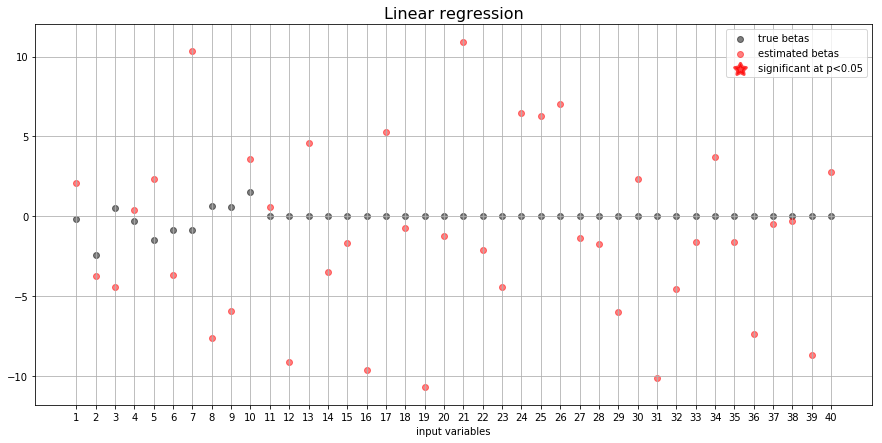

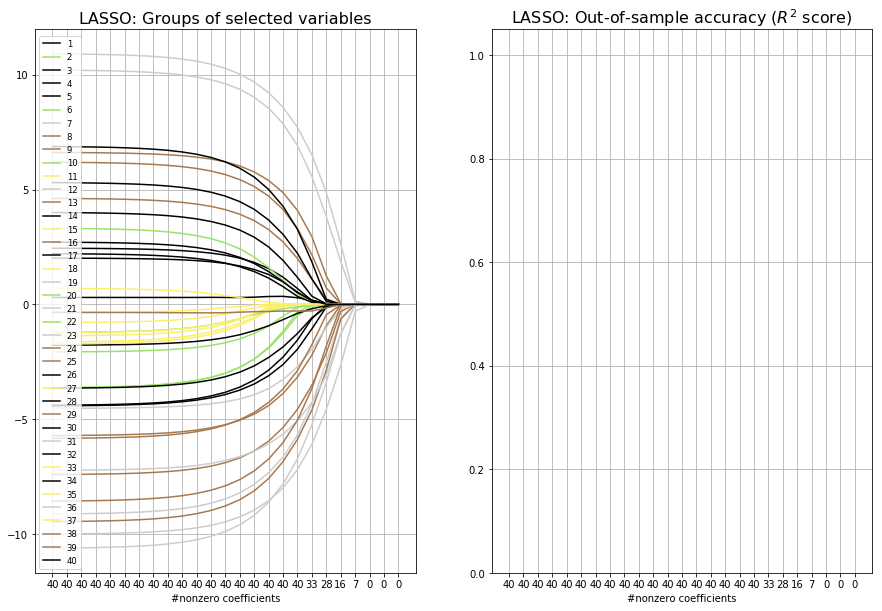

In [133]:
# 1/x / dataset: 10/40 relevant variables, including 5 pathological ones, linear ground truth, some noise
rs = np.random.RandomState(1)
n_samples = 1000
n_feat = 40
n_feat_relevant = 10
epsilon = rs.randn(n_samples)
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)

X_inv = X.copy()
X_inv[:, 0:6] = 1. / X_inv[:, 0:6]  # introduce pathological transformation, NOT captured by ground-truth model
y = (true_coefs * X_inv).sum(axis=1) + epsilon

# ordinary least squares
model = OLS(y, X)
res = model.fit()
lr_coefs = res.params
lr_pvalues = res.pvalues

# compute Lasso regularization paths
C_grid = np.logspace(-2, 1.5, 25)
coef_list, acc_list, nonzero_list = compute_Lasso_regpath(X, y, C_grid)

plot_lr(true_coefs, lr_coefs, lr_pvalues)
plot_regr_paths(coef_list, acc_list, nonzero_list, C_grid)

### observation: 0/5 path. variables are significant, the 0/5 path. variables are selected as predictive